# LSTM

In [1]:
import io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

## Load Subword tokens for IMDB Dataset

In [2]:
imdb_subwords, info_subwords = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDLE2ZV/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDLE2ZV/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDLE2ZV/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
tokenizer = info_subwords.features['text'].encoder

## Prepare Dataset

###### Note: To make the training go faster in this lab, you will increase the batch size that Laurence used in the lecture. In particular, you will use 256 and this takes roughly a minute to train per epoch

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = imdb_subwords['train'], imdb_subwords['test'],

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

## Create Model - Single layer LSTM

- We will simply swap the Flatten or GlobalAveragePooling1D from before with an LSTM layer
- Moreover, we will nest it inside a Biderectional layer so the passing of the sequence information goes both forwards and backwards
- These additional computations will naturally make the training go slower than the models
- We should take this into account when using RNNs in our own applications

In [5]:
embedding_dim = 64
lstm_dim = 64
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598209 (2.28 MB)
Trainable params: 598209 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train Model

In [7]:
NUM_EPOCHS = 10

history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 43s 338ms/step - loss: 0.6204 - accuracy: 0.6406 - val_loss: 0.5780 - val_accuracy: 0.7032
Epoch 2/10
98/98 [==============================] - 29s 294ms/step - loss: 0.3876 - accuracy: 0.8358 - val_loss: 0.4337 - val_accuracy: 0.8262
Epoch 3/10
98/98 [==============================] - 25s 258ms/step - loss: 0.2818 - accuracy: 0.8920 - val_loss: 0.4331 - val_accuracy: 0.8076
Epoch 4/10
98/98 [==============================] - 26s 267ms/step - loss: 0.4197 - accuracy: 0.8065 - val_loss: 0.4898 - val_accuracy: 0.8029
Epoch 5/10
98/98 [==============================] - 25s 252ms/step - loss: 0.2587 - accuracy: 0.9008 - val_loss: 0.4888 - val_accuracy: 0.8187
Epoch 6/10
98/98 [==============================] - 27s 276ms/step - loss: 0.2186 - accuracy: 0.9214 - val_loss: 0.4530 - val_accuracy: 0.8151
Epoch 7/10
98/98 [==============================] - 23s 231ms/step - loss: 0.1886 - accuracy: 0.9362 - val_loss: 0.5250 - val_accuracy: 0.8188

### Visualize Training

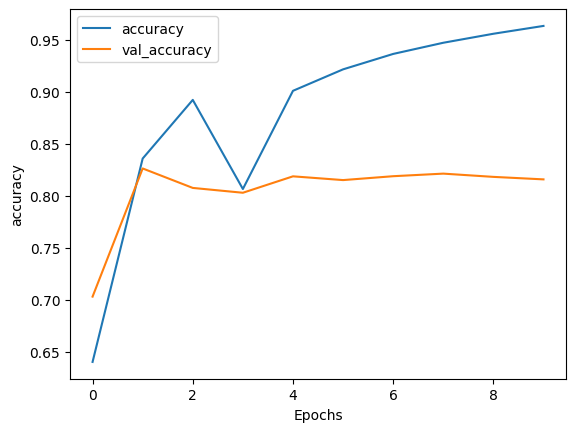

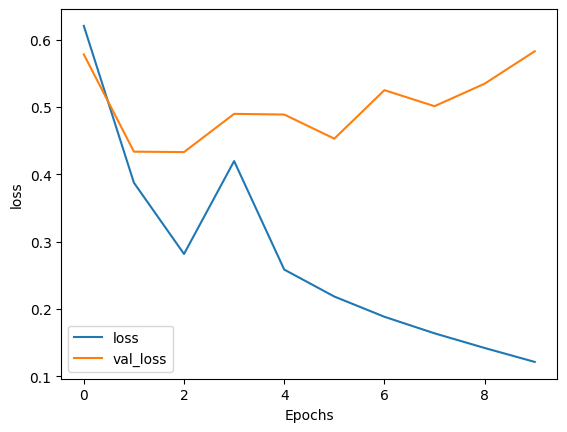

In [8]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Create Model - Multi-layer LSTM

In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = imdb_subwords['train'], imdb_subwords['test'],

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

### Build and compile model

- We can build multiple layer LSTM models by simply appending another LSTM layer in our Sequential model and enabling the return_sequences flag to True
- This is because an LSTM layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well
- We'll notice that the output dimension is in 3 dimensions (batch_size, timesteps, features) when when return_sequences is True

In [10]:
# Hyperparameters
batch_size = 1
timesteps = 20
features = 16
lstm_dim = 8

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'lstm output units: {lstm_dim}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps,features)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


In [11]:
# Hyperparameters
embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635329 (2.42 MB)
Trainable params: 63532

In [12]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train model

In [13]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 54s 476ms/step - loss: 0.6214 - accuracy: 0.6494 - val_loss: 0.5564 - val_accuracy: 0.7693
Epoch 2/10
98/98 [==============================] - 44s 447ms/step - loss: 0.3854 - accuracy: 0.8406 - val_loss: 0.3701 - val_accuracy: 0.8444
Epoch 3/10
98/98 [==============================] - 42s 428ms/step - loss: 0.2770 - accuracy: 0.8951 - val_loss: 0.3621 - val_accuracy: 0.8591
Epoch 4/10
98/98 [==============================] - 41s 417ms/step - loss: 0.2167 - accuracy: 0.9214 - val_loss: 0.3919 - val_accuracy: 0.8444
Epoch 5/10
98/98 [==============================] - 40s 407ms/step - loss: 0.1632 - accuracy: 0.9436 - val_loss: 0.4794 - val_accuracy: 0.8473
Epoch 6/10
98/98 [==============================] - 40s 404ms/step - loss: 0.1512 - accuracy: 0.9483 - val_loss: 0.4453 - val_accuracy: 0.8444
Epoch 7/10
98/98 [==============================] - 40s 403ms/step - loss: 0.1133 - accuracy: 0.9623 - val_loss: 0.5834 - val_accuracy: 0.8367

### Visualize training

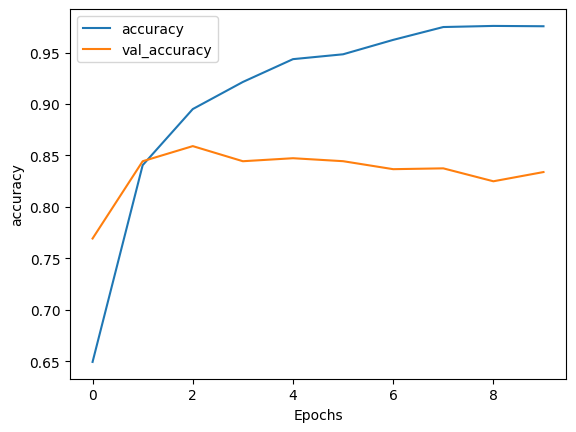

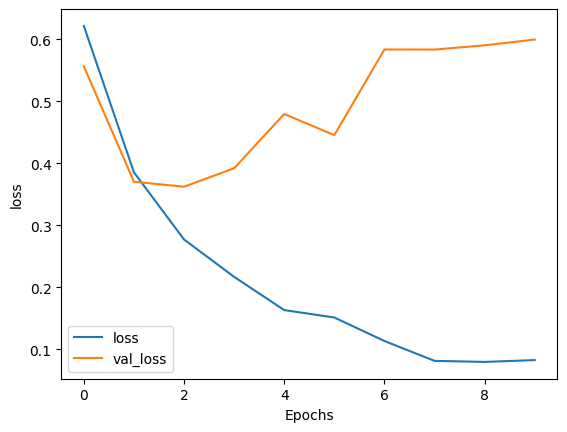

In [14]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")